# Visualization and loading dataset

## load data of participant data

In [1]:
import csv
import numpy as np

from load_subject import load_subject_data


In [2]:
# Create an empty list to store the dictionaries
participants_info = []
subjects = []

# Open the file in read mode
with open('../participants.tsv', 'r') as f:
    # Create a DictReader object with tab as the delimiter
    reader = csv.DictReader(f, delimiter='\t')
    # Iterate over the rows of the reader
    for row in reader:
        # Append each row as a dictionary to the list
        participants_info.append(row)

# Print the list of dictionaries
print(participants_info[0])


{'participant_id': 'sub-001', 'Original_ID': '8010', 'Group': 'CTL', 'sess1_Med': 'n/a', 'sess2_Med': 'no s2', 'sex': 'Female', 'age': '61'}


In [3]:
subjects.append(load_subject_data(0, participants_info))
subjects.append(load_subject_data(1, participants_info))
subjects.append(load_subject_data(2, participants_info))

Reading e:\SUT\Neuro-RA\Coding\RewP\myCode\..\sub-001\ses-01\eeg\sub-001_ses-01_task-ReinforcementLearning_eeg.fdt


e:\SUT\Neuro-RA\Coding\RewP\myCode\load_subject.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file)


Reading e:\SUT\Neuro-RA\Coding\RewP\myCode\..\sub-002\ses-01\eeg\sub-002_ses-01_task-ReinforcementLearning_eeg.fdt


e:\SUT\Neuro-RA\Coding\RewP\myCode\load_subject.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file)


Reading e:\SUT\Neuro-RA\Coding\RewP\myCode\..\sub-002\ses-02\eeg\sub-002_ses-02_task-ReinforcementLearning_eeg.fdt


e:\SUT\Neuro-RA\Coding\RewP\myCode\load_subject.py:32: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_file)


In [4]:
events_types = set(subjects[0]['events']['type'])
print((events_types))

{'Instr: "Choose"', 'Left Button Choice', 'FB: 0', 'FB: +1', 'STATUS', 'Imperative Stimulus', 'Right Button Choice', 'FB: "No Match"', 'FB: "Too Slow"', 'Instr: "Match"'}


In [5]:
print(subjects[0]["EEG"].shape)

(67, 704900)


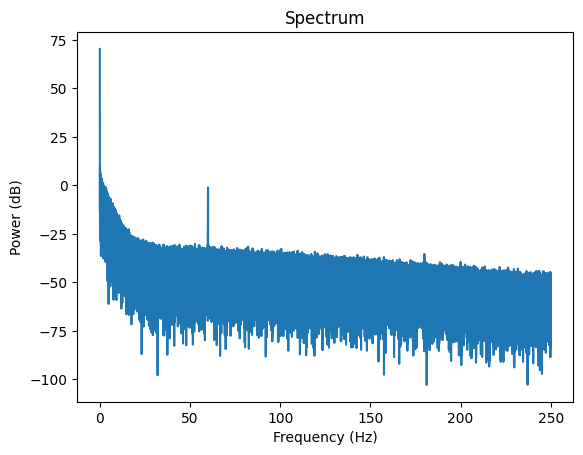

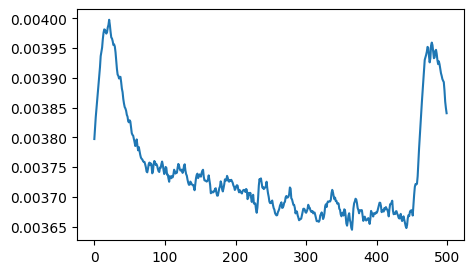

In [6]:
# filter data

import matplotlib.pyplot as plt
from signal_processing import plot_spectrum

fs = 500
plot_spectrum(subjects[0]["EEG"][0,:], fs)

plt.figure
plt.rcParams['figure.figsize'] = (5,3)
plt.plot(subjects[0]["EEG"][0,0:fs])

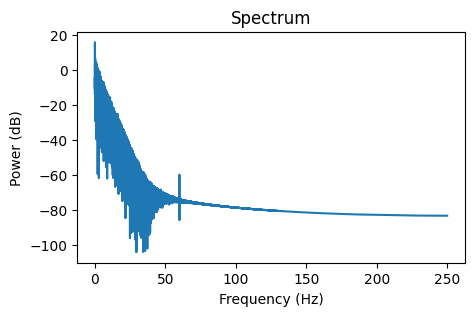

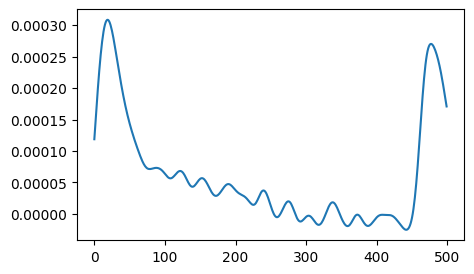

In [7]:
from signal_processing import bp_filter

subjects[0]["EEG"] = bp_filter(subjects[0]["EEG"], 0.01, 20, 3, fs)

plot_spectrum(subjects[0]["EEG"][0,:], fs)

plt.figure
plt.rcParams['figure.figsize'] = (5, 3)
plt.plot(subjects[0]["EEG"][0,0:fs])

In [8]:
subjects[1]["EEG"] = bp_filter(subjects[1]["EEG"], 0.01, 20, 3, fs)
subjects[2]["EEG"] = bp_filter(subjects[2]["EEG"], 0.01, 20, 3, fs)

c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


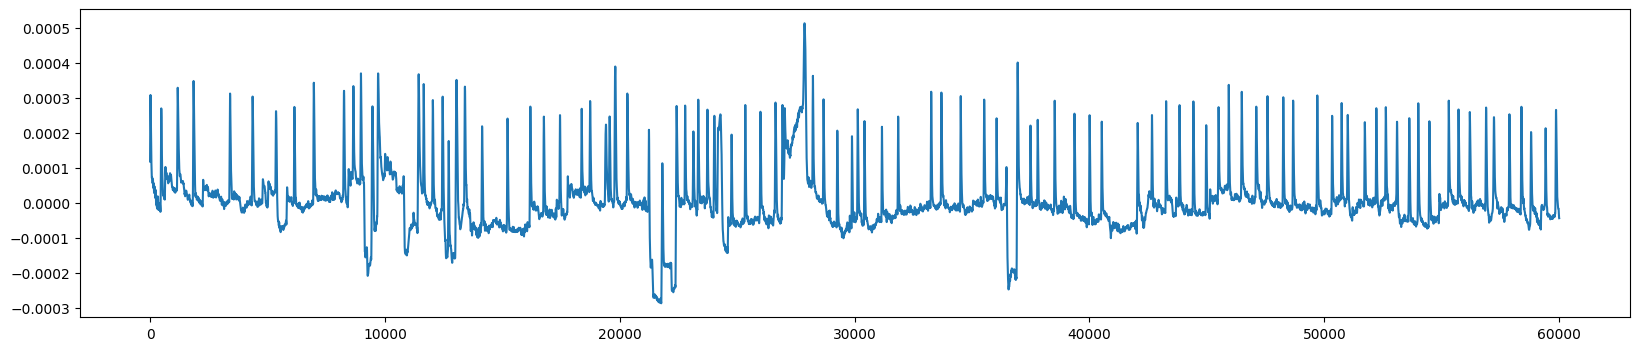

In [9]:
from sklearn.decomposition import FastICA

X = subjects[0]["EEG"][:,0:120*fs].T

# plot original data
plt.rcParams['figure.figsize'] = (20,4)
plt.plot(X.T[0,:])

# Run ICA on your data
ica = FastICA(n_components=X.shape[1]) # we want *all* the components
ica.fit(X)

# Decompose your data into independent components
components = ica.transform(X) # shape = (n_samples, n_components)


(60000, 67)


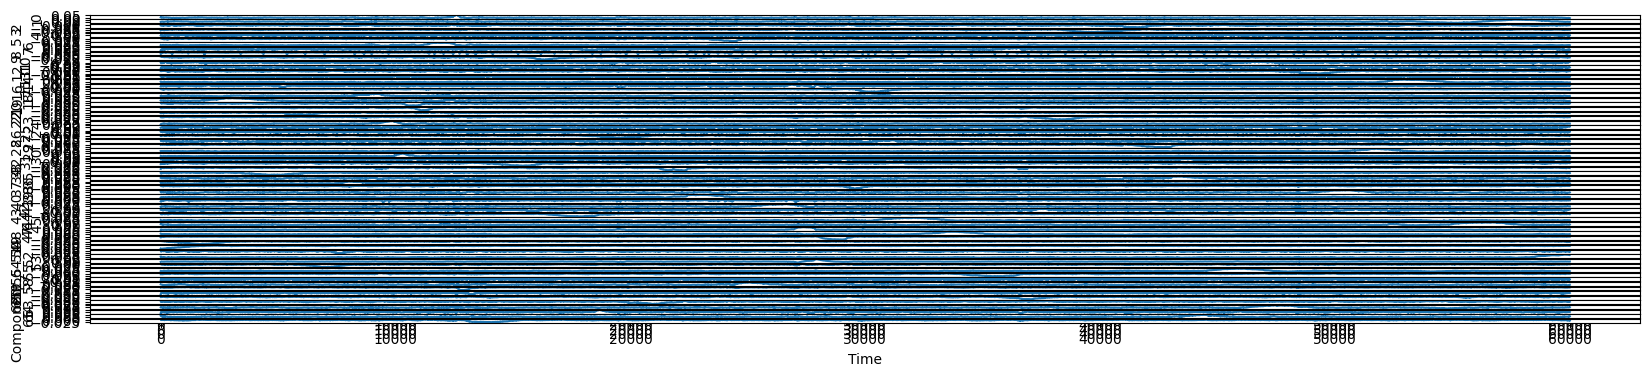

In [10]:
# Plot the components and inspect them visually to identify the ones that contain eye blinks or other artifacts
print(components.shape)
plt.figure()
plt.rcParams['figure.figsize'] = (10,50)

for i in range(components.shape[1]):    
    plt.subplot(components.shape[1], 1, i+1)
    plt.plot(components.T[i,:])
    plt.ylabel(i)
    
plt.xlabel('Time')
plt.ylabel('Component')
plt.show()

In [11]:
print(np.where(np.max(abs(components), 0) > 0.75*np.max(abs(components))))

(array([ 0, 20, 23, 30, 37, 50, 53, 59], dtype=int64),)


In [12]:
remove_indices = list(np.where(np.max(components, 0) > 0.08))  # pretend the user selected components 0, 1, and 3

# "remove" unwanted components by setting them to 0 - simplistic but gets the job done
components[:, remove_indices] = 0

#reconstruct signal
X_restored = ica.inverse_transform(components)

(60000, 67)


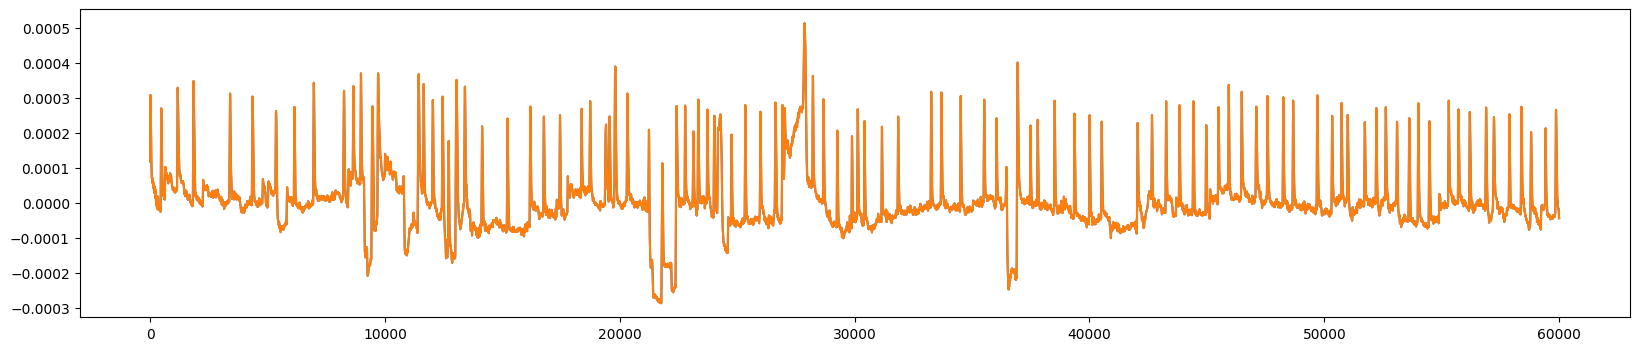

In [13]:
print(X_restored.shape)

plt.figure
plt.rcParams['figure.figsize'] = (20,4)
plt.plot(X_restored.T[0,:])

plt.figure
plt.rcParams['figure.figsize'] = (20,4)
plt.plot(X.T[0,:])


In [14]:
from signal_processing import remove_ICA
subjects[0]["EEG"] = remove_ICA(subjects[0]["EEG"]).T
subjects[1]["EEG"] = remove_ICA(subjects[1]["EEG"]).T
subjects[2]["EEG"] = remove_ICA(subjects[2]["EEG"]).T

c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
c:\Users\Moh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [15]:
from preprocess import cluster_events_by_type

sub1_events_clus = cluster_events_by_type(subjects[0]['events']['onset'], subjects[0]['events']['type'])
del sub1_events_clus['STATUS']
sub2_events_clus = cluster_events_by_type(subjects[1]['events']['onset'], subjects[1]['events']['type'])
del sub2_events_clus['STATUS']
sub3_events_clus = cluster_events_by_type(subjects[2]['events']['onset'], subjects[2]['events']['type'])
del sub3_events_clus['STATUS']

In [16]:
from preprocess import cluster_and_epoch

fs = 500
epoch_limits = np.array([-0.3, 1])
baseline_limits = np.array([-0.2, 0])
cluster_and_epoch(subjects[0], sub1_events_clus, fs, epoch_limits, baseline_limits)
cluster_and_epoch(subjects[1], sub2_events_clus, fs, epoch_limits, baseline_limits)
cluster_and_epoch(subjects[2], sub3_events_clus, fs, epoch_limits, baseline_limits)


In [17]:
print(subjects[0]['epochs']['Left Button Choice'].shape)
print(subjects[1]['epochs']['Left Button Choice'].shape)
print(subjects[2]['epochs']['Left Button Choice'].shape)

(67, 651, 148)
(67, 651, 143)
(67, 651, 49)


In [18]:
# calculate and plot ERPs

from preprocess import calc_ERP

calc_ERP(subjects[0])
calc_ERP(subjects[1])
calc_ERP(subjects[2])

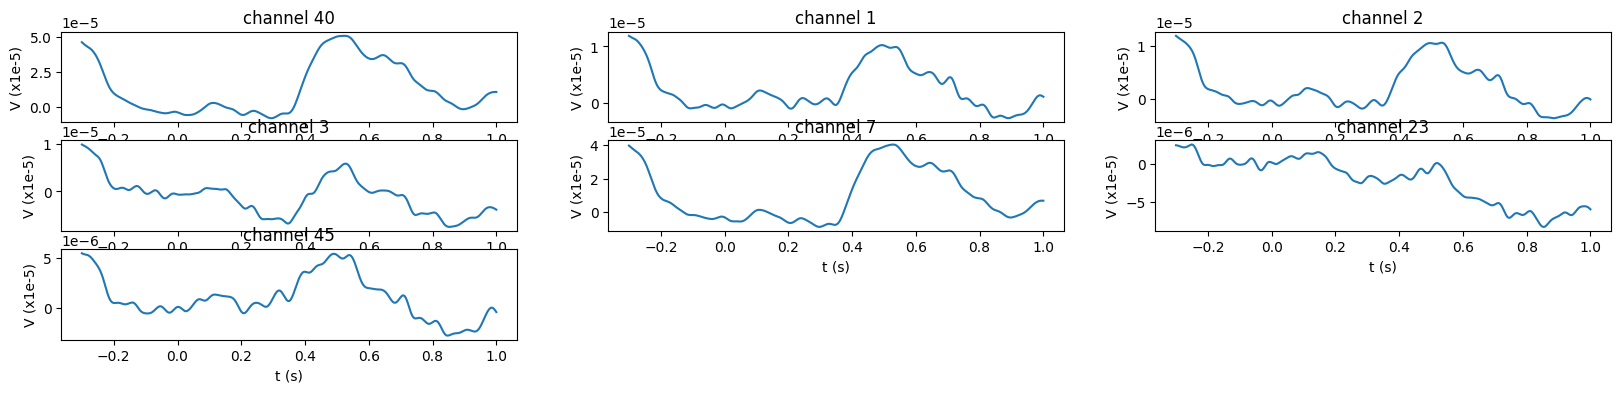

In [19]:
from preprocess import plot_ERP

plot_ERP(subjects[0]['ERP']['FB: +1'], [-0.3, 1], [40, 1, 2, 3, 7, 23, 45])

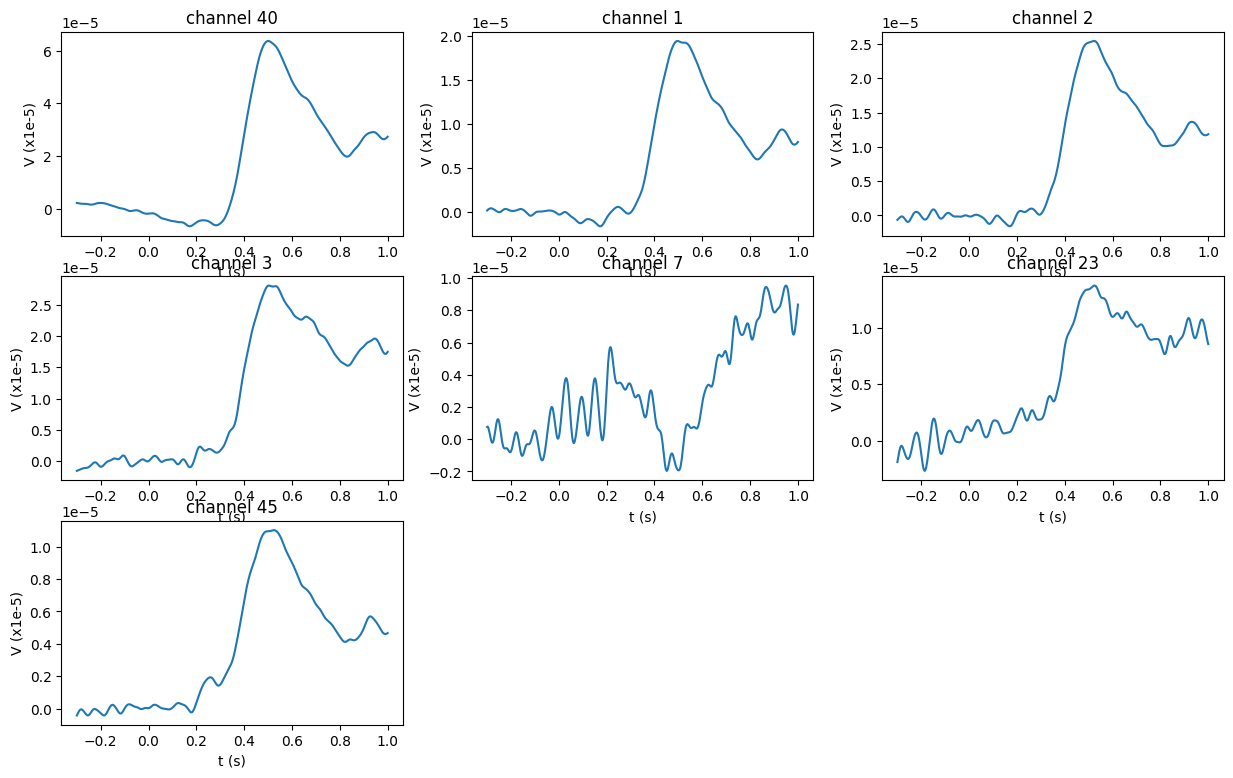

In [20]:
plot_ERP(subjects[1]['ERP']['FB: +1'], [-0.3, 1], [40, 1, 2, 3, 7, 23, 45])

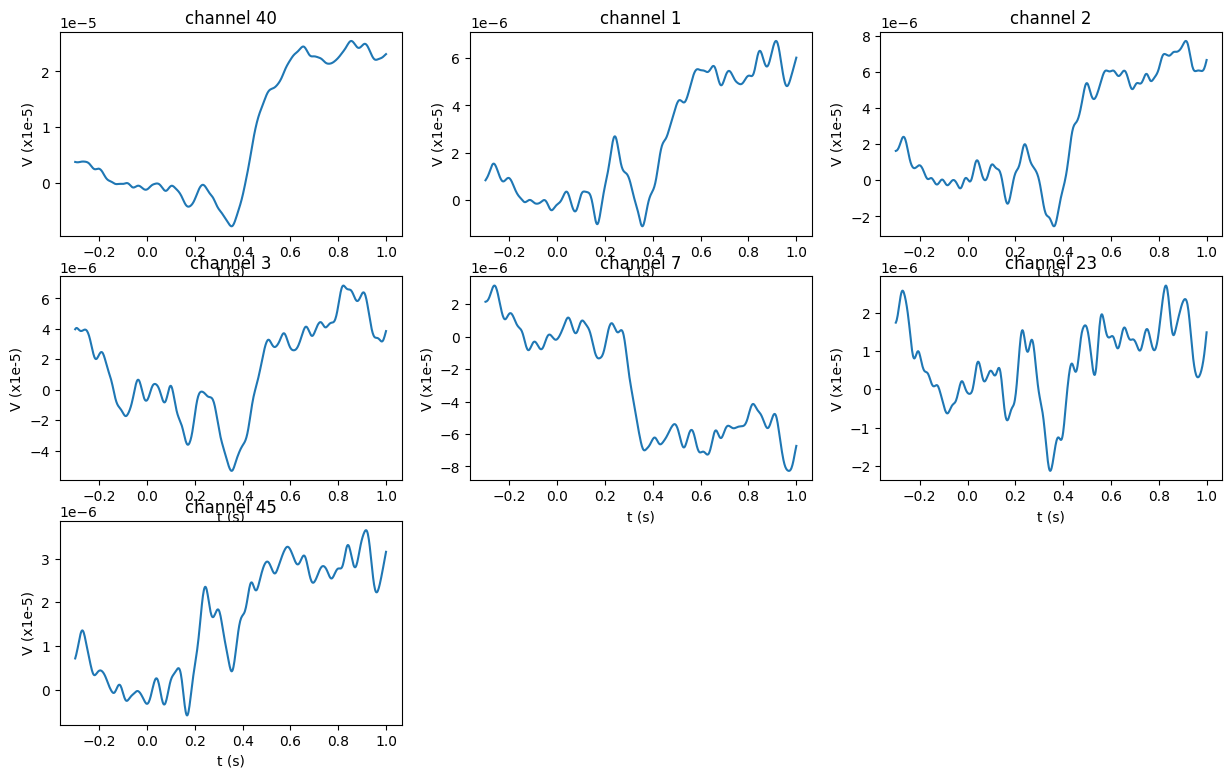

In [21]:
plot_ERP(subjects[2]['ERP']['FB: +1'], [-0.3, 1], [40, 1, 2, 3, 7, 23, 45])

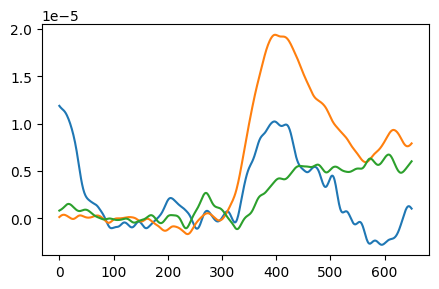

In [22]:
plt.figure
plt.rcParams['figure.figsize'] = (5,3)
plt.plot(subjects[0]['ERP']['FB: +1'][1,:])
plt.plot(subjects[1]['ERP']['FB: +1'][1,:])
plt.plot(subjects[2]['ERP']['FB: +1'][1,:])